In [640]:
import pandas as pd

from global_constants import *

from os.path import join

import csv

from scipy.spatial.distance import cdist

from sklearn.neural_network import MLPClassifier

from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [649]:
number_of_train_features = 2048

In [697]:
def get_ordered_data_frame(csv_path, mode='train', ):
    data_frame = pd.read_csv(join(data_path, csv_path), names=["name"] + [str(k) for k in range(number_of_train_features)])
    data_frame["file_name_index"] = pd.to_numeric(data_frame.name.str.extract("((?<=[images_" + mode + "\/])\d*(?=\.))", expand=False))
    data_frame.sort_values('file_name_index', inplace=True)
    return data_frame

def get_normalised_prob(prediction_weights):
    normalizing_factor = sum(prediction_weights)
    return np.array(prediction_weights)/normalizing_factor

In [698]:
input_1000_data = get_ordered_data_frame('features_train/features_resnet1000intermediate_train.csv')
X = input_1000_data[[str(k) for k in range(number_of_train_features)]].as_matrix()

better_tag_data = pd.read_csv('better_train_3_tags_nouns.csv')
better_tag_data[better_tag_data != 0] = 1

Y = better_tag_data.as_matrix()

test_input_1000_data = get_ordered_data_frame('features_test/features_resnet1000intermediate_test.csv', "test")     
X_Test = test_input_1000_data[[str(k) for k in range(number_of_train_features)]].as_matrix()

better_tag_test_data = pd.read_csv('better_test_3_tags_nouns.csv')
better_tag_test_data = normalize_rows(better_tag_test_data.as_matrix(), minimum_number_of_labels)

In [762]:
classifier = MLPClassifier(hidden_layer_sizes=(750), verbose=True, max_iter=15, warm_start=True)

In [763]:
classifier.fit(X, Y)

Iteration 1, loss = 203.15386529
Iteration 2, loss = 57.79312617
Iteration 3, loss = 46.80155324
Iteration 4, loss = 42.41323238
Iteration 5, loss = 40.03821956
Iteration 6, loss = 38.41100720
Iteration 7, loss = 37.22895080
Iteration 8, loss = 36.25611072
Iteration 9, loss = 35.44820958
Iteration 10, loss = 34.68961568
Iteration 11, loss = 34.03547980
Iteration 12, loss = 33.40419164
Iteration 13, loss = 32.85917845
Iteration 14, loss = 32.29985135
Iteration 15, loss = 31.74859233


/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=750, learning_rate='constant',
       learning_rate_init=0.001, max_iter=15, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=True)

In [764]:
classifier.score(X,Y)

0.00040000000000000002

In [768]:
def normalize_rows(matrix, minimum_number_of_labels, binary_predictions=None):
    matrix_argsort = matrix.argsort()
    
    # Iterate over i
    for i in range(len(matrix)):

        # Decide number to roll with
        number_to_use = minimum_number_of_labels
        
        # Zero out other values
        for k in range(len(matrix[i])):
            matrix[i][k] = 0 if k not in matrix_argsort[i][-number_to_use:] else matrix[i][k]

        # normalize
        matrix[i] = get_normalised_prob(matrix[i])

        # Sanity Check
        # print(sum(matrix[i]))
        
    return matrix

Y_test = classifier.predict(X_Test)
Y_test_proba = classifier.predict_proba(X_Test)

# constants
minimum_number_of_labels = 11

In [769]:
Y_test_proba = normalize_rows(Y_test_proba, minimum_number_of_labels, Y_test)

1.0


In [770]:
for k in Y_test_proba[402]:
    if k != 0:
        print(k)

0.0513323334495
0.0639979880972
0.0515795344702
0.0447660456792
0.132932990827
0.098862888697
0.0894780958531
0.0988978471352
0.108337789524
0.128076893868
0.131737592399


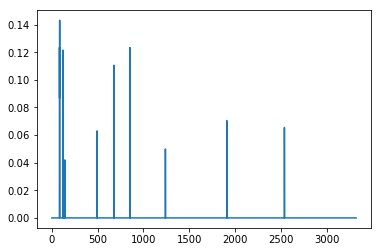

In [771]:
plt.plot(better_tag_test_data[0])

[ 0.  0.  0. ...,  0.  0.  0.]


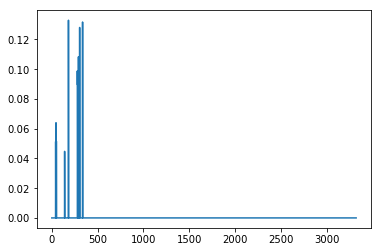

In [772]:
i_check=402
print(Y_test_proba[i_check])
plt.plot(Y_test_proba[i_check])

In [773]:
for index, k in enumerate(Y_test_proba[i_check]):
    if k != 0:
        print(index)
        print(better_tag_data.columns[index])

42
people
46
snowboarder
50
group
140
sky
182
snow
280
skier
281
hill
282
snowy
291
ski
304
slope
336
mountain


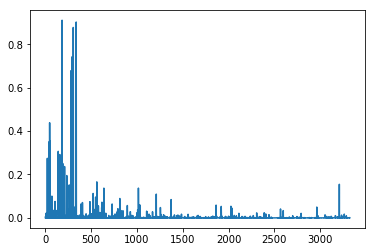

In [774]:
plt.plot(classifier.predict_proba([X_Test[i_check]])[0])

In [776]:
simi=cdist(better_tag_test_data, Y_test_proba, metric='cosine')
rows=[['Descritpion_ID', 'Top_20_Image_IDs']]
for i in range(len(better_tag_test_data)):
    buffer1=[]
    buffer1=simi[i].argsort()[:20]
    rows.append([str(i) + ".txt", " ".join([str(value) + ".jpg" for value in buffer1])])
csv.writer(open("submission_try.csv", "w")).writerows(rows)

In [781]:
d_check=0
output_statement = rows[d_check + 1][1]

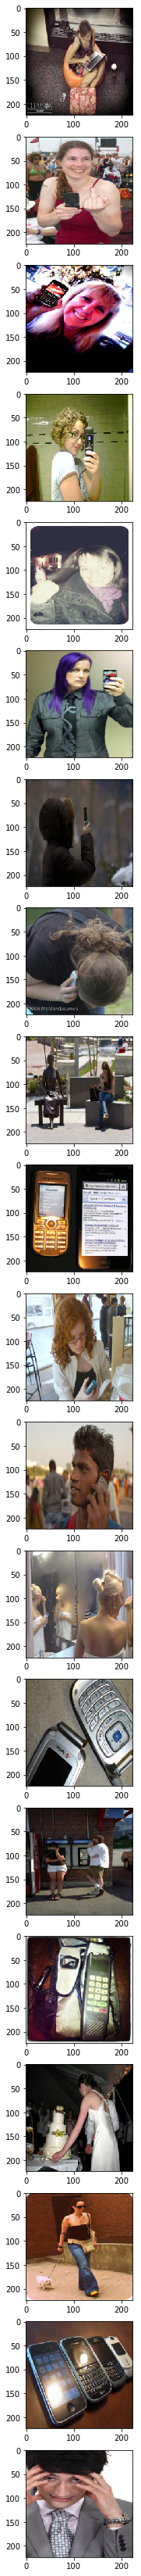

In [782]:
import matplotlib.image as mpimg
f, ax = plt.subplots(nrows=20, ncols=1, figsize=(60,60))
for index, image_1 in enumerate(output_statement.split()):
    img=mpimg.imread('data/images_test/' + image_1)

    ax[index].imshow(img)